In [41]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import os
import pandas as pd
import random
import shutil
from sklearn.preprocessing import MinMaxScaler

# GENERATE THE GRAPHS IN DIFFERENT TIMEFRAMES

From the initial dataset of https://www.kaggle.com/datasets/kacobe/btcusdt that has a timeframe of 1min, generate the other timeframes

In [ ]:
graphs_folder = 'BTCUSD_graphs'

print("Loading raw dataframe from https://www.kaggle.com/datasets/kacobe/btcusdt. Download it manually and paste it in the file system ;)")
df = pd.read_csv('BTCUSDT_klines_all.csv')

print("Removing \"Close time\", \"Quote asset volume\", \"Number of trades\", \"Taker buy base asset volume\", \"Taker buy quote asset volume\" and \"Ignore\" columns")
df.drop(["Close time", 'Quote asset volume', "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"], axis=1, inplace=True)

print("Renaming \"Open Time\" column to \"Date\" and modifying format to YYYY-mm-dd H:M")
df.rename(columns={'Open time': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])  # Ensure it's in datetime format

print("Setting 'Date' column as index")
df.set_index('Date', inplace=True)

print("Rounding Float columns to 2 decimals")
columns_to_round = ['Open', 'High', 'Low', 'Close', 'Volume']
df[columns_to_round] = df[columns_to_round].round(2)

print("Creating graphs folder")
if os.path.exists(graphs_folder):
    shutil.rmtree(graphs_folder)
os.makedirs(graphs_folder, exist_ok=True)

print(f"Saving dataframe to {graphs_folder}/BTCUSD_1T.csv")
df.to_csv(f"{graphs_folder}/BTCUSD_1T.csv")

print("Generating graphs of other timeframes")
timeframes = ['5T', '15T', '1H', '1D', '1W', '1M']
for timeframe in timeframes:
    print(f"Generating {timeframe} timeframe")
    resampled_df = df.resample(timeframe).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    # Remove NA rows
    resampled_df.dropna(inplace=True)
    # Round numbers to 2 decimal places
    resampled_df = resampled_df.round(2)
    filename=f'{graphs_folder}/BTCUSD_{timeframe}.csv'
    resampled_df.to_csv(filename)

print("Zipping folder")
zipname = f'{graphs_folder}.zip'
!zip -r {zipname} {g_graphs_folder}
print("Done!")


Loading raw dataframe from https://www.kaggle.com/datasets/kacobe/btcusdt. Download it manually and paste it in the file system ;)
Removing "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume" and "Ignore" columns
Renaming "Open Time" column to "Date" and modifying format to YYYY-mm-dd H:M
Setting 'Date' column as index
Rounding Float columns to 2 decimals
Creating graphs folder
Saving dataframe to BTCUSD_graphs/BTCUSD_1T.csv
Generating graphs of other timeframes
Generating 5T timeframe
Generating 15T timeframe
Generating 1H timeframe
Generating 1D timeframe
Generating 1W timeframe
Generating 1M timeframe
Zipping folder
  adding: BTCUSD_graphs/ (stored 0%)
  adding: BTCUSD_graphs/BTCUSD_1D.csv (deflated 60%)
  adding: BTCUSD_graphs/BTCUSD_1T.csv (deflated 72%)
  adding: BTCUSD_graphs/BTCUSD_1M.csv (deflated 55%)
  adding: BTCUSD_graphs/BTCUSD_1W.csv (deflated 57%)
  adding: BTCUSD_graphs/BTCUSD_5T.csv (deflated 70%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


# GENERATE NEW DATASETS WITH OUTPUT COLUMN

Add a column that indicates if a trade should be taken from each candle (1) is a long (0) is not long.

The long TP and SL is calculated as a percentage of the volatility

In [ ]:
def ft_add_trade_outputs(df, sl_multiplier=0.125, tp_multiplier=0.25, std_n=14, std_k=2, max_candles=None, output_column_name="Output"):
    # Create new row "Output" that indicates whether a long would be successful (1) or not (0)
    df[output_column_name] = 0

    # Create dataset with the standard deviation of the last n candles
    std_df = df['Close'].rolling(window=std_n).std() * std_k

    for i in range(len(df)):
        # Define the StopLoss and TakeProfit based on the volatility
        SL = df['Close'].iloc[i] - std_df.iloc[i] * sl_multiplier
        TP = df['Close'].iloc[i] + std_df.iloc[i] * tp_multiplier

        candles_count = 0
        for j in range(i + 1, len(df)):
            # Check max amount of candles reached
            if max_candles is not None and candles_count >= max_candles:
                break
            # If the candle touches both high and low don't count it as long
            if df['Low'].iloc[j] <= SL and df['High'].iloc[j] >= TP:
                df.loc[df.index[i], output_column_name] = 0
                break
            # Else if touches the TP, is long
            elif df['High'].iloc[j] >= TP:
                df.loc[df.index[i], output_column_name] = 1
                break
            # Else if touches SL is not long
            elif df['Low'].iloc[j] <= SL:
                df.loc[df.index[i], output_column_name] = 0
                break
            candles_count += 1

        if (i % (len(df) // 10) == 0):
            print(f"Processed {i // (len(df) // 10) * 10}% candles")
    return df

In [ ]:
# n= number of candles for the standard deviation, k = 2 means 95% of values
g_n = 14
g_k = 2
g_sl_multiplier = 0.125
g_tp_multiplier = 0.25
g_timeframes = ['1M','1W','1D','1H','15T','5T','1T']
g_folder_name = 'BTCUSD_graphs'
g_filename='BTCUSD'
g_output_folder = 'BTCUSD_output'
g_output_filename = 'BTCUSD_output'
g_max_candles_dict = {
    '1T': 240, #4h
    '5T': 96, #8h
    '15T': 96, #24h
    '1H': 72, #3D
    '1D': 30, #1M
    '1W': 12, #3M
    '1M': 12 #1Y
}

# Create the output folder
print(f"Creating {g_output_folder} folder")
if os.path.exists(g_output_folder):
    shutil.rmtree(g_output_folder)
os.makedirs(g_output_folder, exist_ok=True)

# Generate the datasets
tmp_output_column_name=f"Output_{str(g_tp_multiplier).replace('.', '')}tp_{str(g_sl_multiplier).replace('.', '')}sl"
for timeframe in g_timeframes:
    # Read the file for this timeframe
    tmp_filename= f'{g_folder_name}/{g_filename}_{timeframe}.csv'
    print(f"Opening dataset {tmp_filename}")
    tmp_df = pd.read_csv(tmp_filename, index_col='Date')
    tmp_df.index = pd.to_datetime(tmp_df.index)

    # Add the trade outputs
    print(f"Adding trade output")
    tmp_df = ft_add_trade_outputs(
        tmp_df,
        sl_multiplier=g_sl_multiplier,
        tp_multiplier=g_tp_multiplier,
        std_n=g_n,
        std_k=g_k,
        max_candles=g_max_candles_dict[timeframe],
        output_column_name=tmp_output_column_name
        )

    # Print data
    tmp_counts = tmp_df[tmp_output_column_name].value_counts()
    tmp_num_longs = tmp_counts.get(1, 0)  # Num of longs
    tmp_num_shorts = tmp_counts.get(0, 0)  # Num of shorts
    print(f"Num longs: {tmp_num_longs}, num shorts: {tmp_num_shorts}")

    tmp_output_path = f'{g_output_folder}/{g_output_filename}_{timeframe}.csv'
    print(f"Saving dataset {tmp_output_path}")
    tmp_df.to_csv(tmp_output_path)

print("Zipping folder")
tmp_zipname = f'{g_output_folder}.zip'
!zip -r {tmp_zipname} {g_output_folder}
print("Done!")

Creating BTCUSD_output folder
Opening dataset BTCUSD_graphs/BTCUSD_1M.csv
Adding trade output
Processed 0% candles
Processed 10% candles
Processed 20% candles
Processed 30% candles
Processed 40% candles
Processed 50% candles
Processed 60% candles
Processed 70% candles
Processed 80% candles
Processed 90% candles
Processed 100% candles
Num longs: 22, num shorts: 59
Saving dataset BTCUSD_output/BTCUSD_output_1M.csv
Opening dataset BTCUSD_graphs/BTCUSD_1W.csv
Adding trade output
Processed 0% candles
Processed 10% candles
Processed 20% candles
Processed 30% candles
Processed 40% candles
Processed 50% candles
Processed 60% candles
Processed 70% candles
Processed 80% candles
Processed 90% candles
Num longs: 103, num shorts: 247
Saving dataset BTCUSD_output/BTCUSD_output_1W.csv
Opening dataset BTCUSD_graphs/BTCUSD_1D.csv
Adding trade output
Processed 0% candles
Processed 10% candles
Processed 20% candles
Processed 30% candles
Processed 40% candles
Processed 50% candles
Processed 60% candles
Pr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


In [35]:
def ft_plot_graphs(df, candles_in_graph=100, num_of_graphs=10, std_n =14, std_k=2):
    def ft_generate_numbers(start, end, count, seed=None):
        if seed is not None:
            random.seed(seed)

        generated_numbers = []
        for _ in range(count):
            number = random.randint(start, end)
            generated_numbers.append(number)

        return generated_numbers

    size = candles_in_graph
    # Create Boolinger bands
    std = df['Close'].rolling(window=std_n).std() * std_k
    high_std = df['Close'] + std
    low_std = df['Close'] - std

    tmp_random_samples= ft_generate_numbers(0, len(df) - candles_in_graph, num_of_graphs)

    for begin in tmp_random_samples:
        # Generate a dataframe with the size of the graph
        graph_vals = df[begin:begin+size]

        # Create a new df with the rows that are a long with the value of the close, and the rows that are not as nan
        trade_markers = graph_vals['Close'].copy()
        trade_markers[graph_vals.iloc[:,-1] != 1] = np.nan

        # Crear la anotación usando la serie de marcadores
        add_plot = mpf.make_addplot(trade_markers, type='scatter', marker='^', color='g', markersize=100)

        # Add the additional plots for close+stdname and close-stdname with semi-transparent blue color
        add_plot_plus_std = mpf.make_addplot(high_std[begin:begin+size], color='b', secondary_y=False, alpha=0.5)
        add_plot_minus_std = mpf.make_addplot(low_std[begin:begin+size], color='b', secondary_y=False, alpha=0.5)

        # Plotear el subconjunto con las anotaciones
        mpf.plot(graph_vals, type='candle', style='charles', volume=True, figsize=(17, 11), addplot=[add_plot,add_plot_minus_std,add_plot_plus_std])

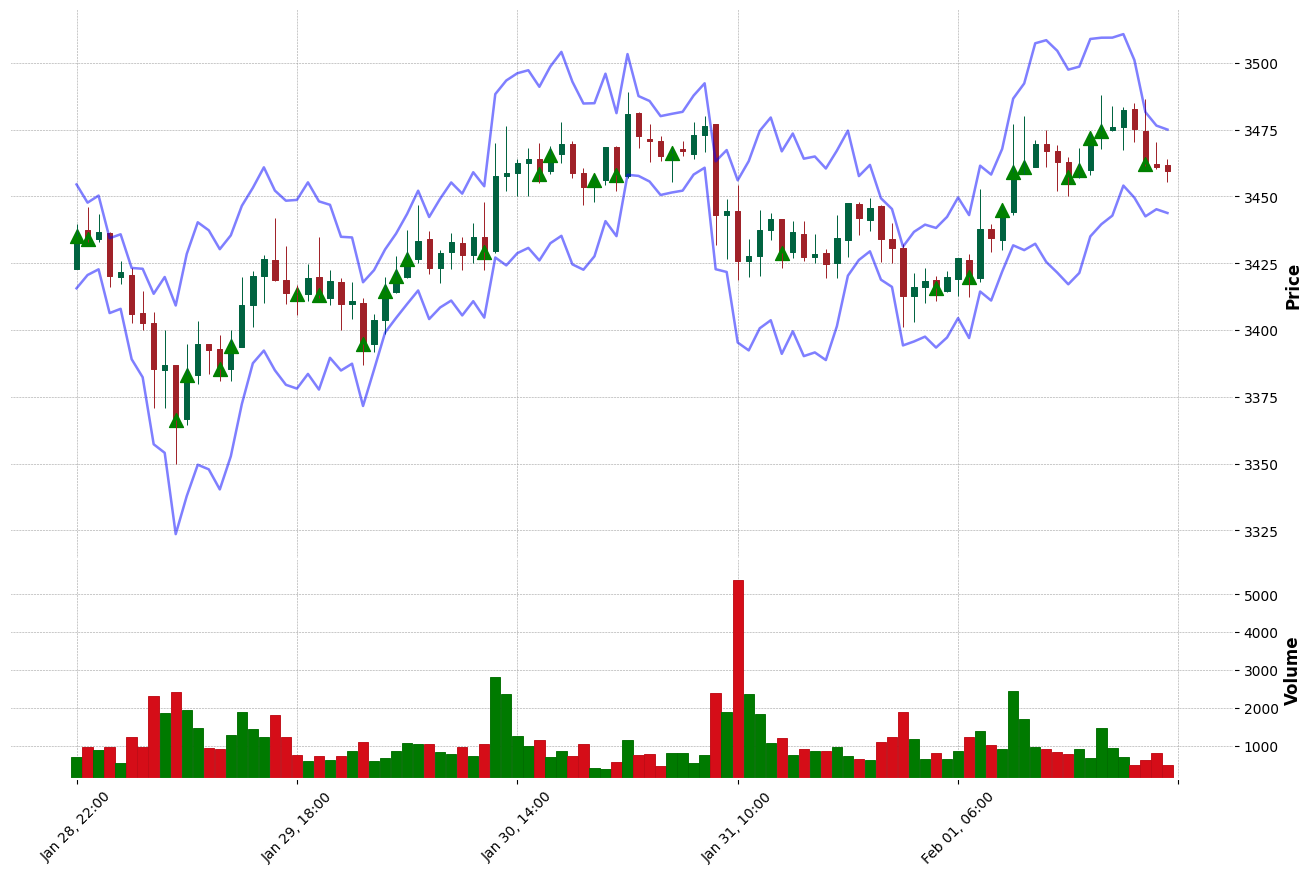

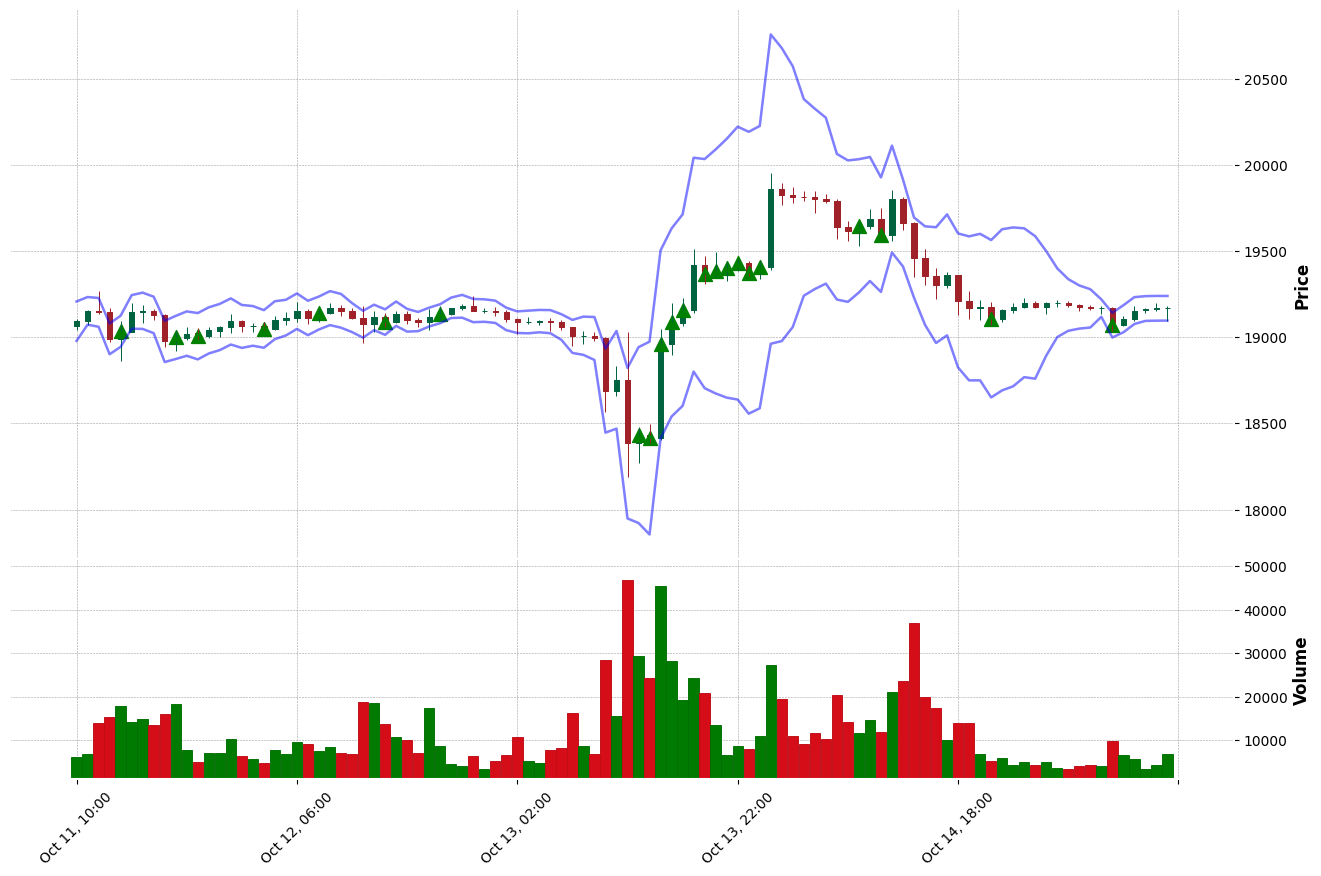

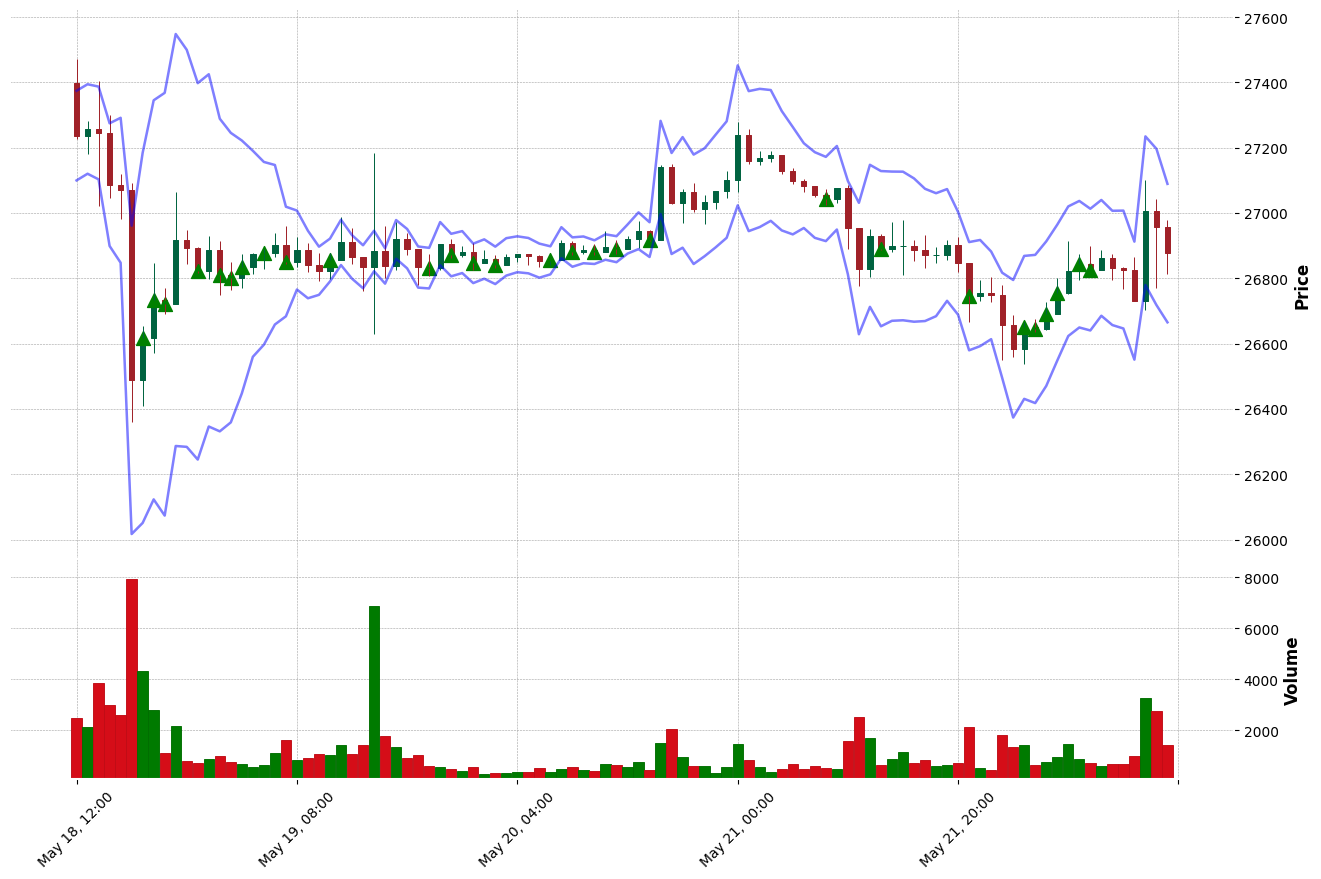

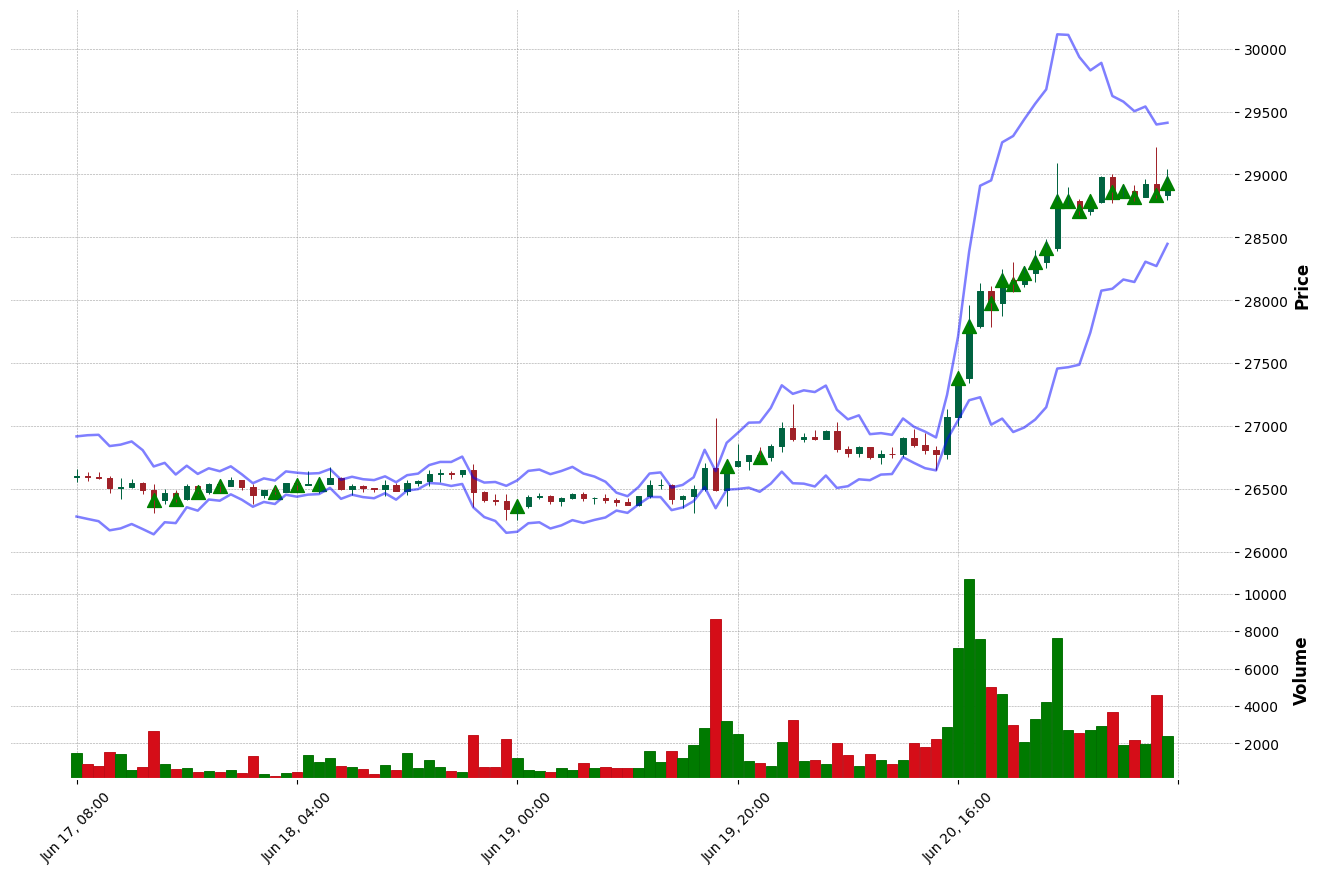

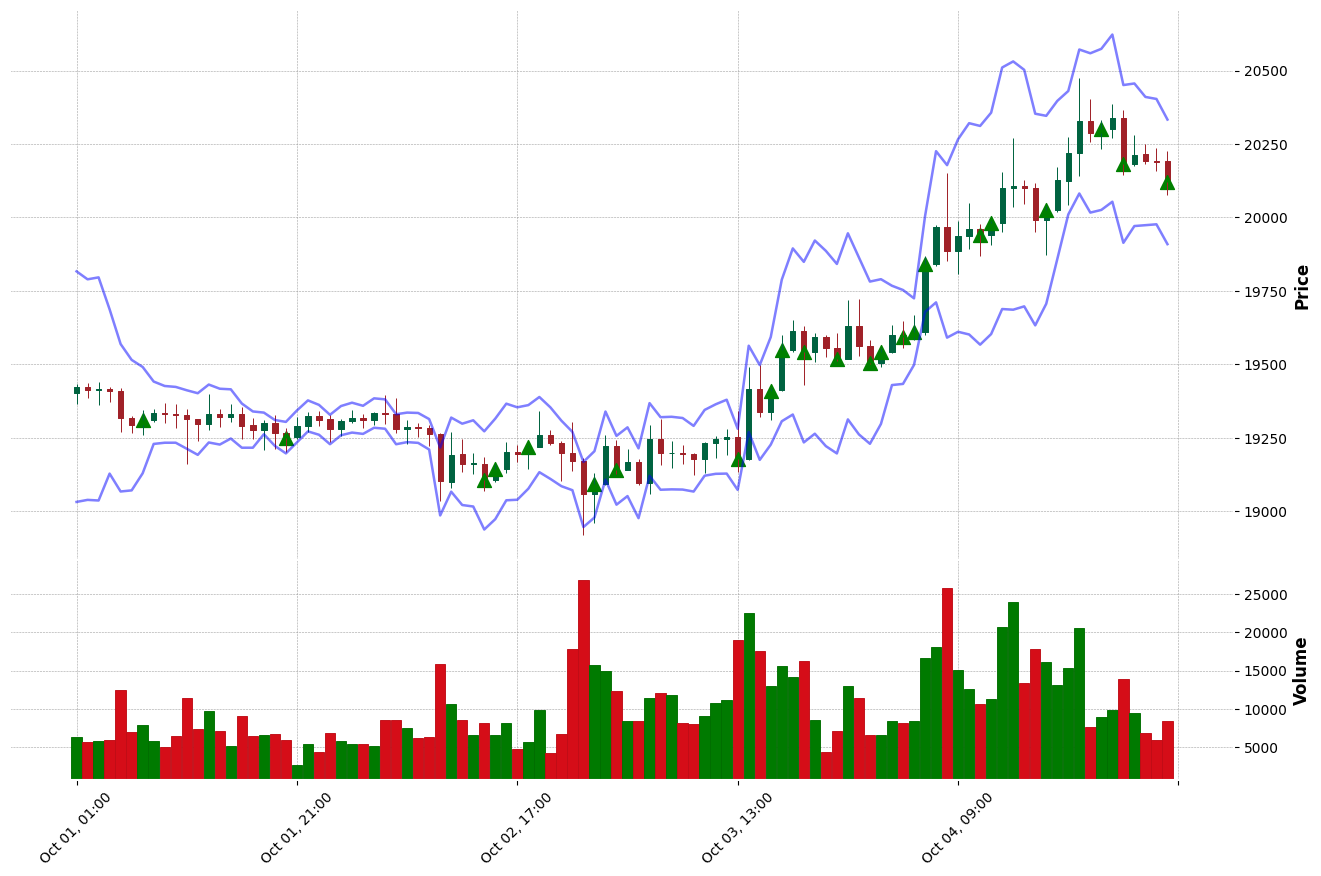

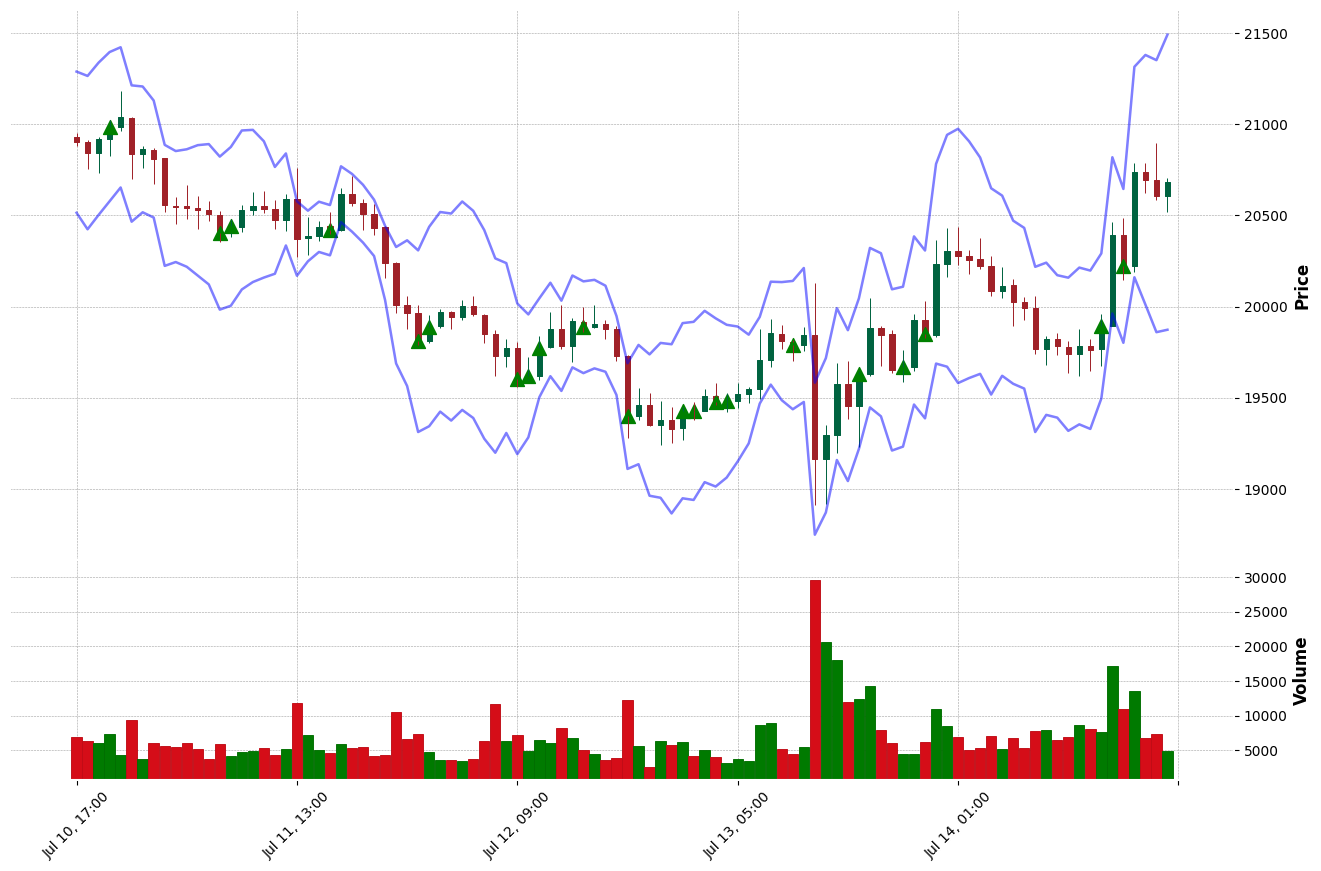

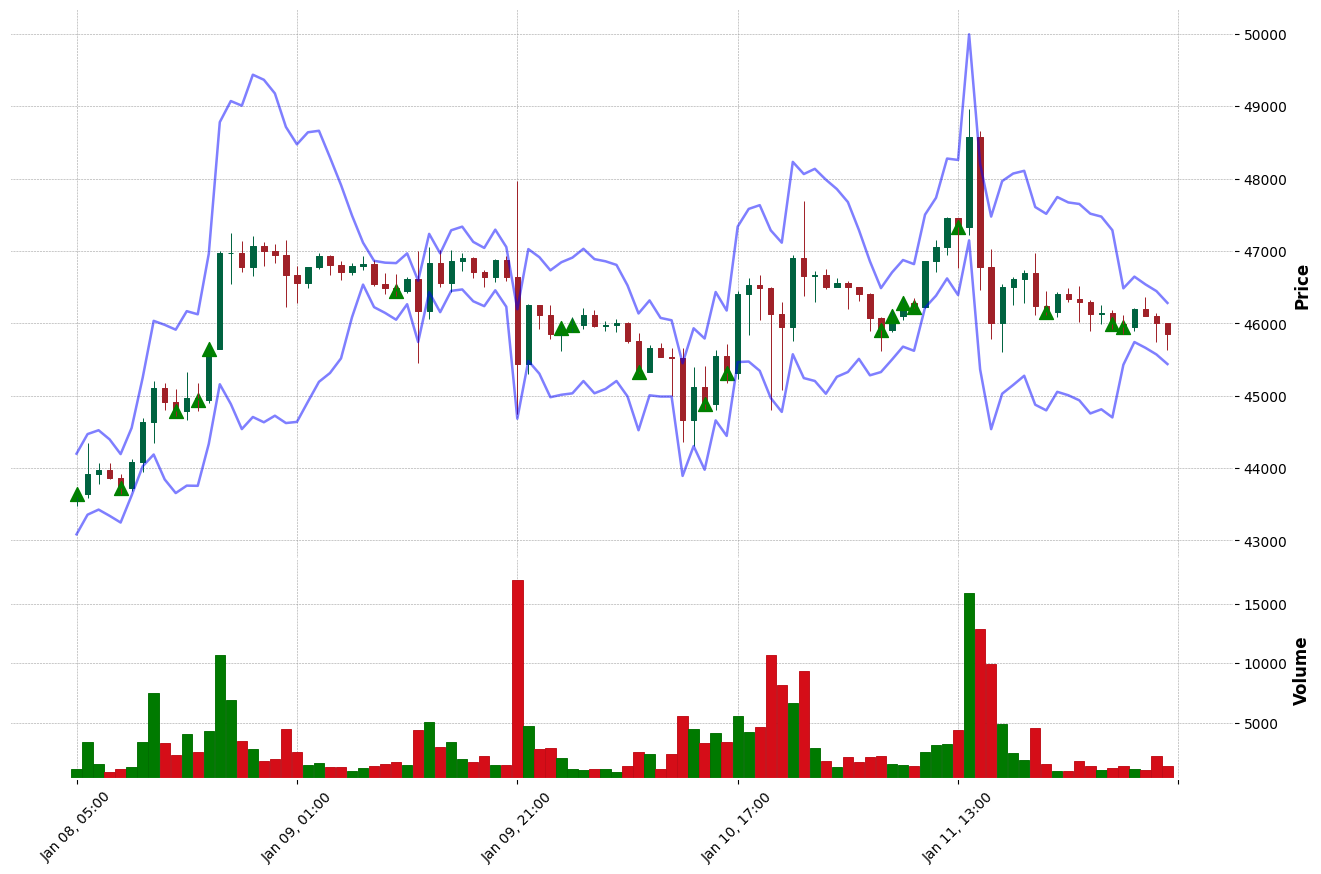

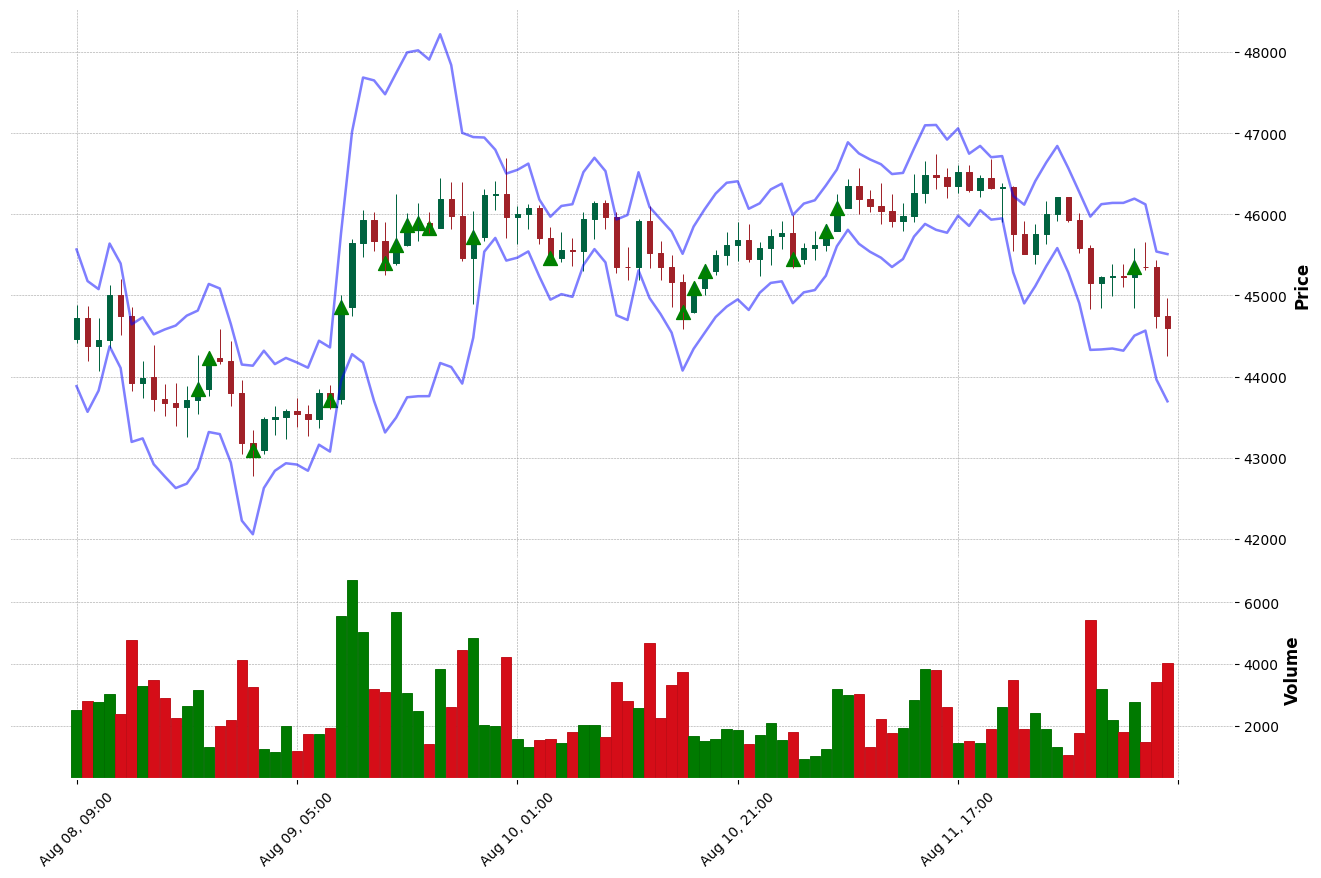

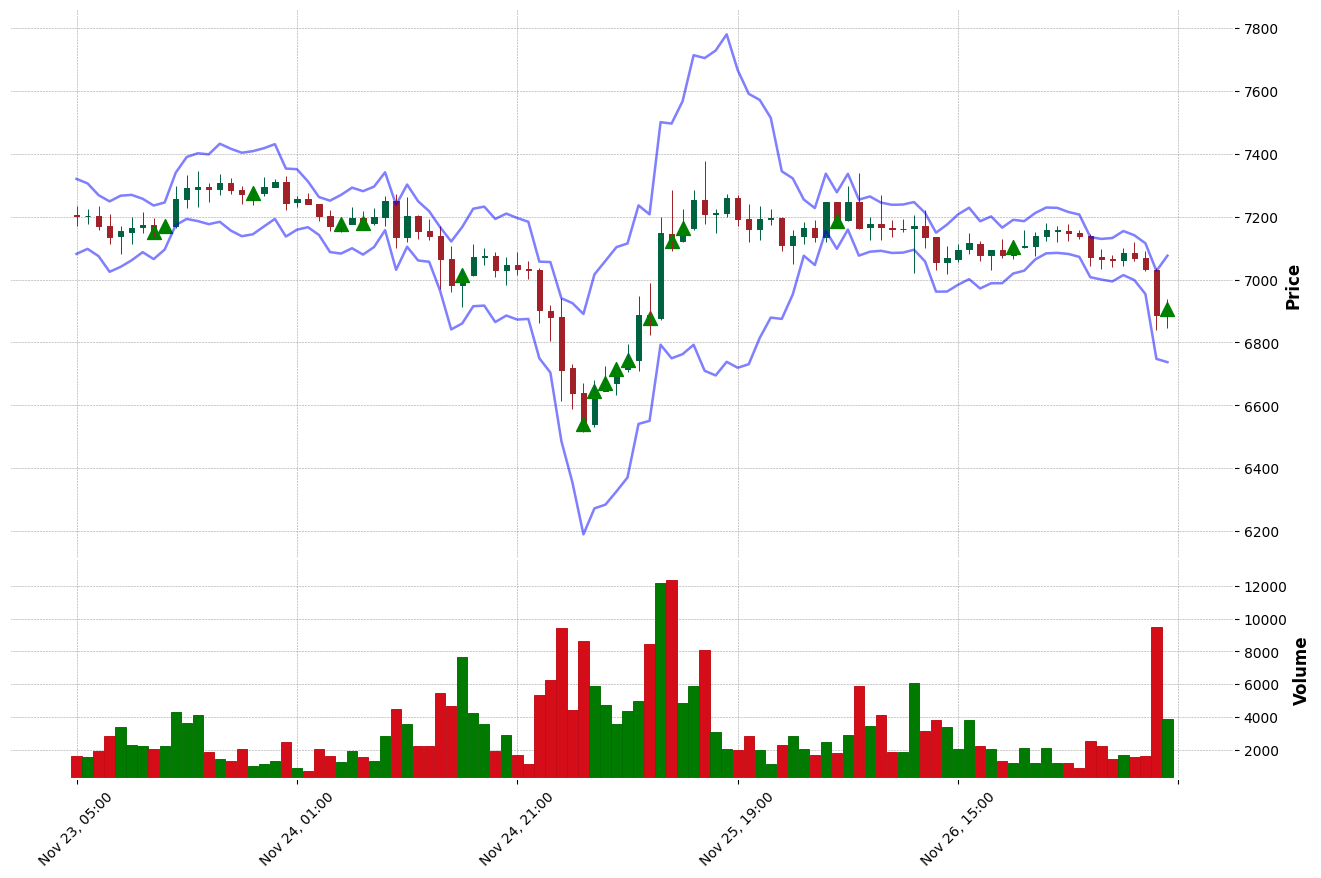

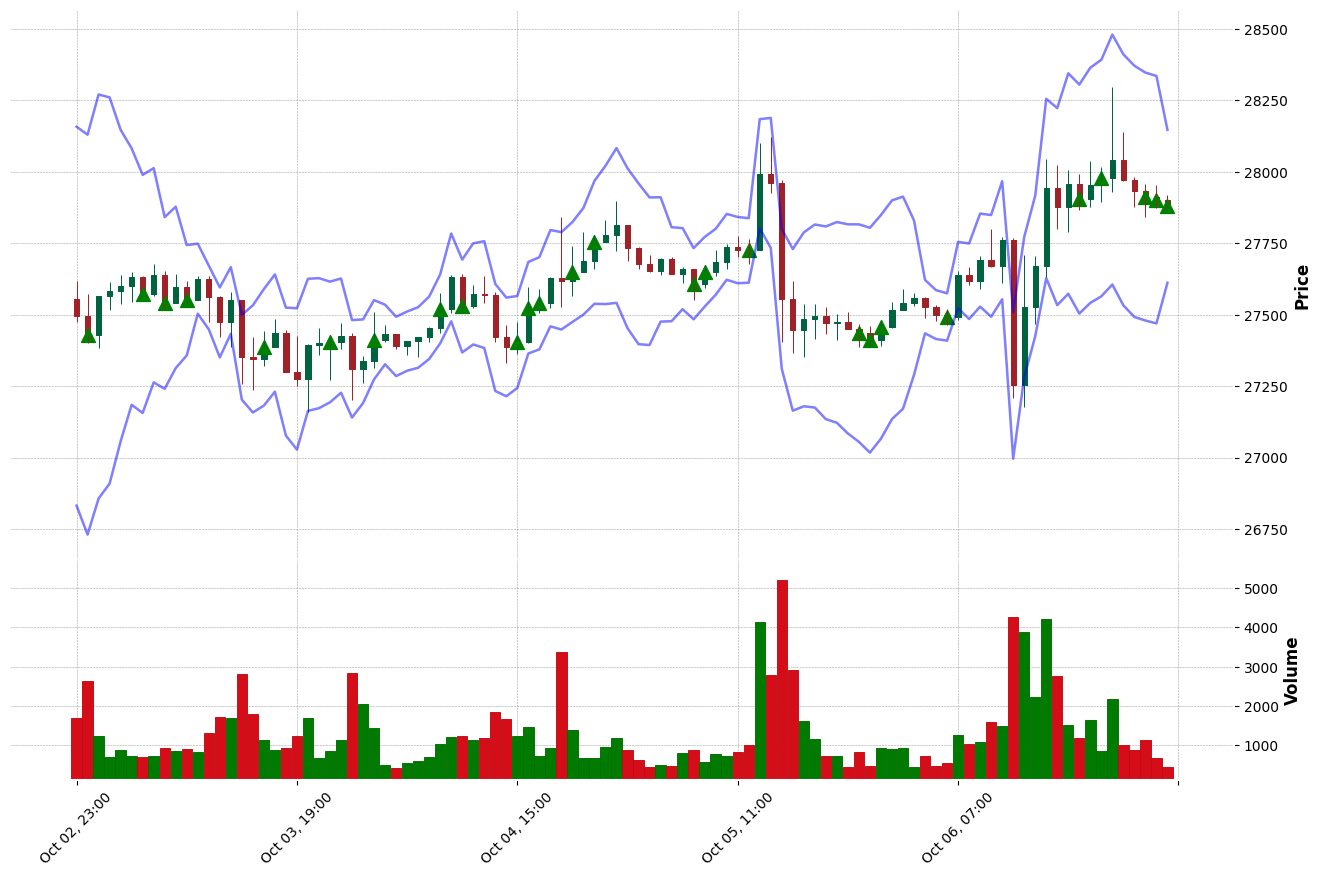

In [36]:
tmp_df = pd.read_csv('BTCUSD_output/BTCUSD_output_1H.csv', index_col='Date')
tmp_df.index = pd.to_datetime(tmp_df.index)
ft_plot_graphs(tmp_df)

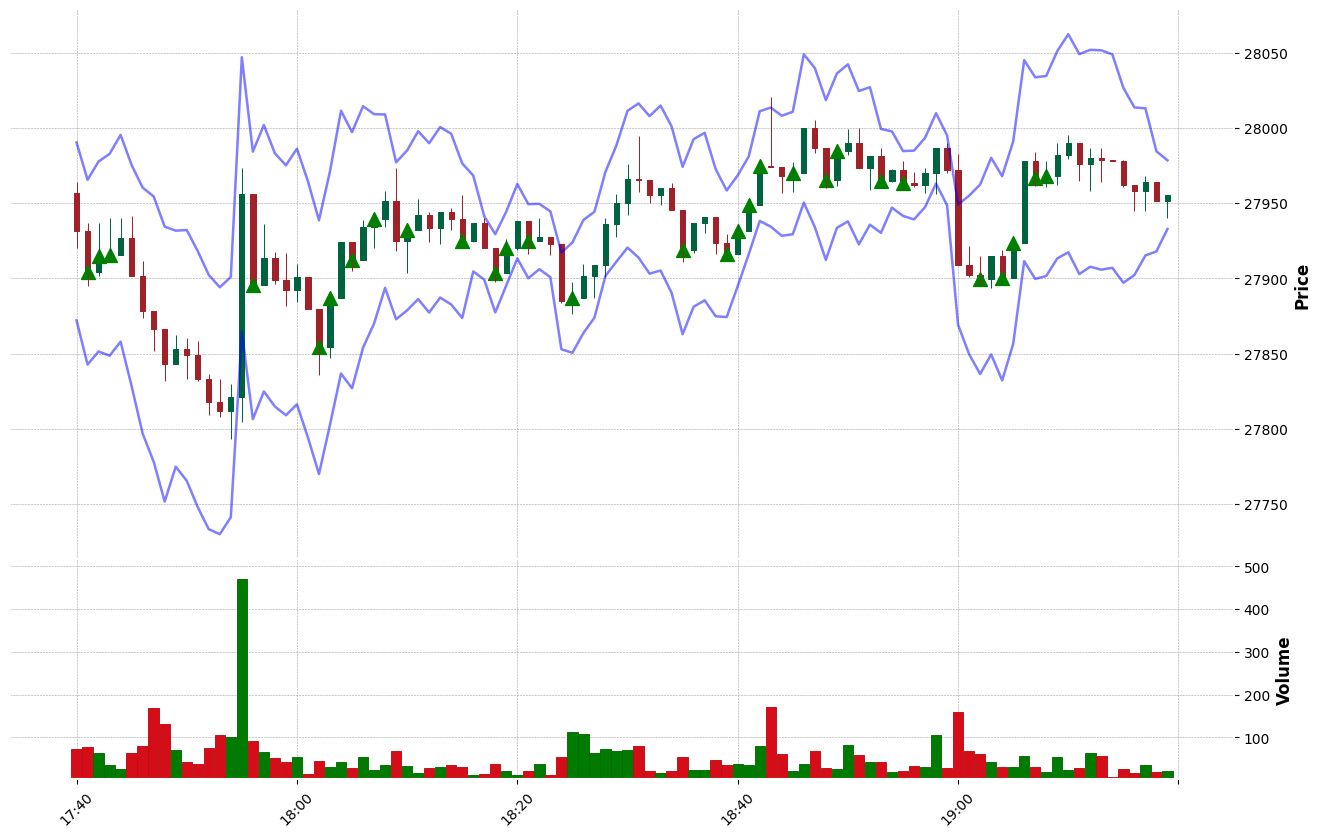

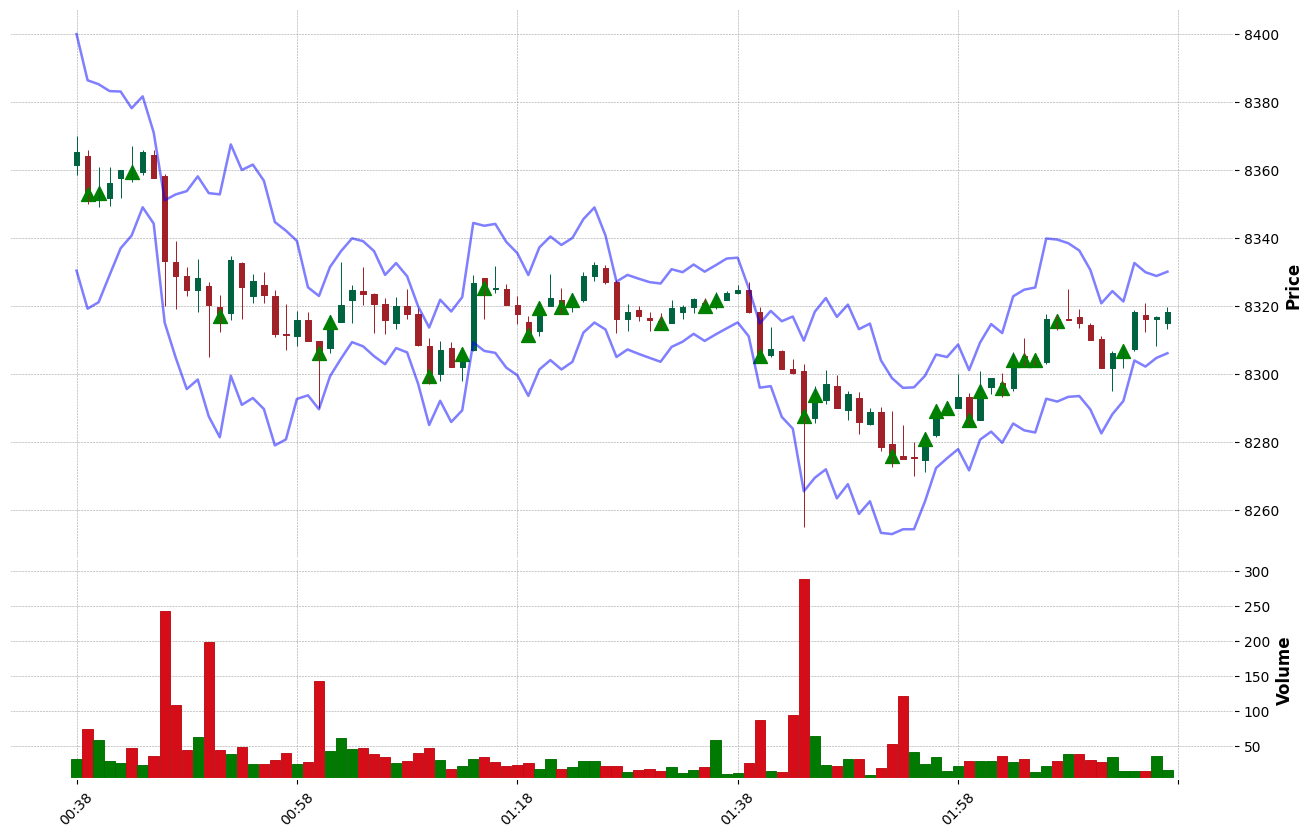

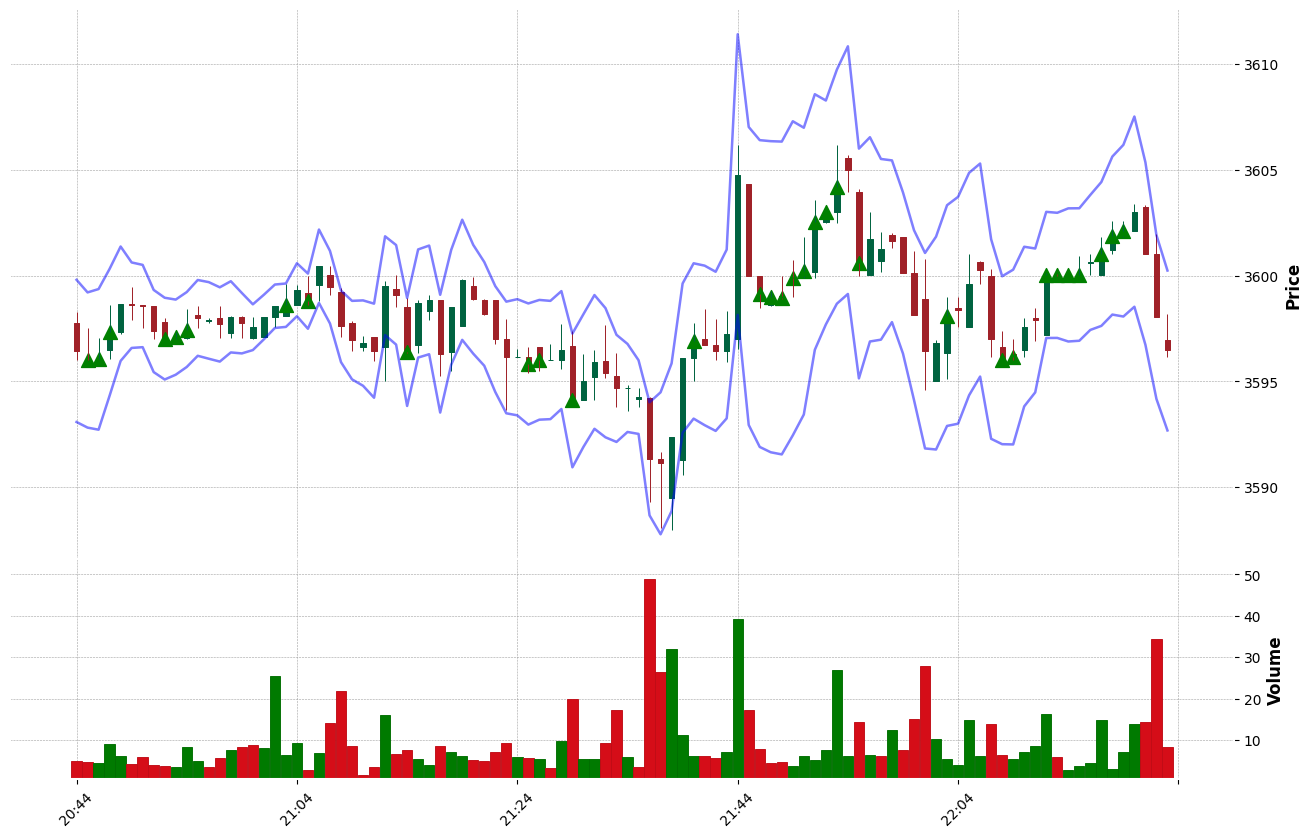

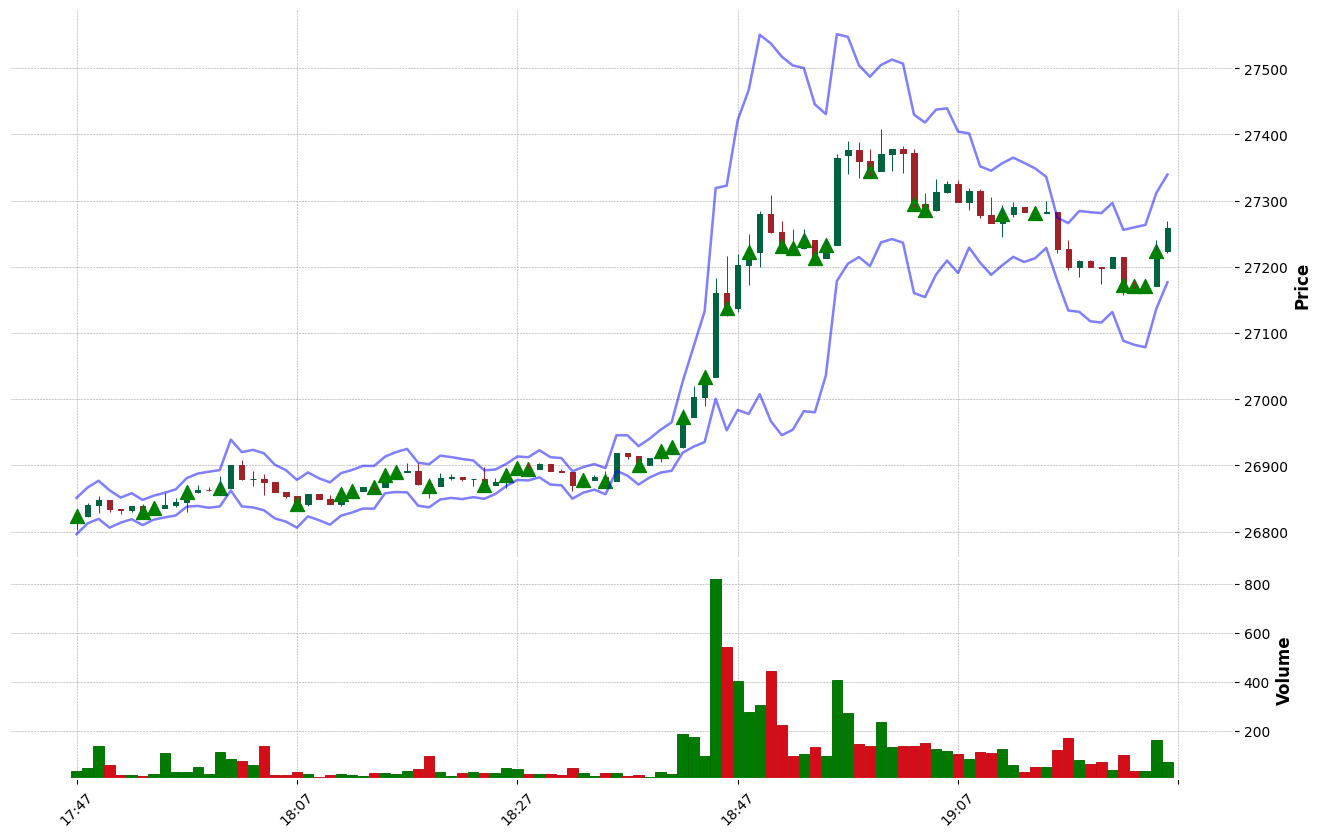

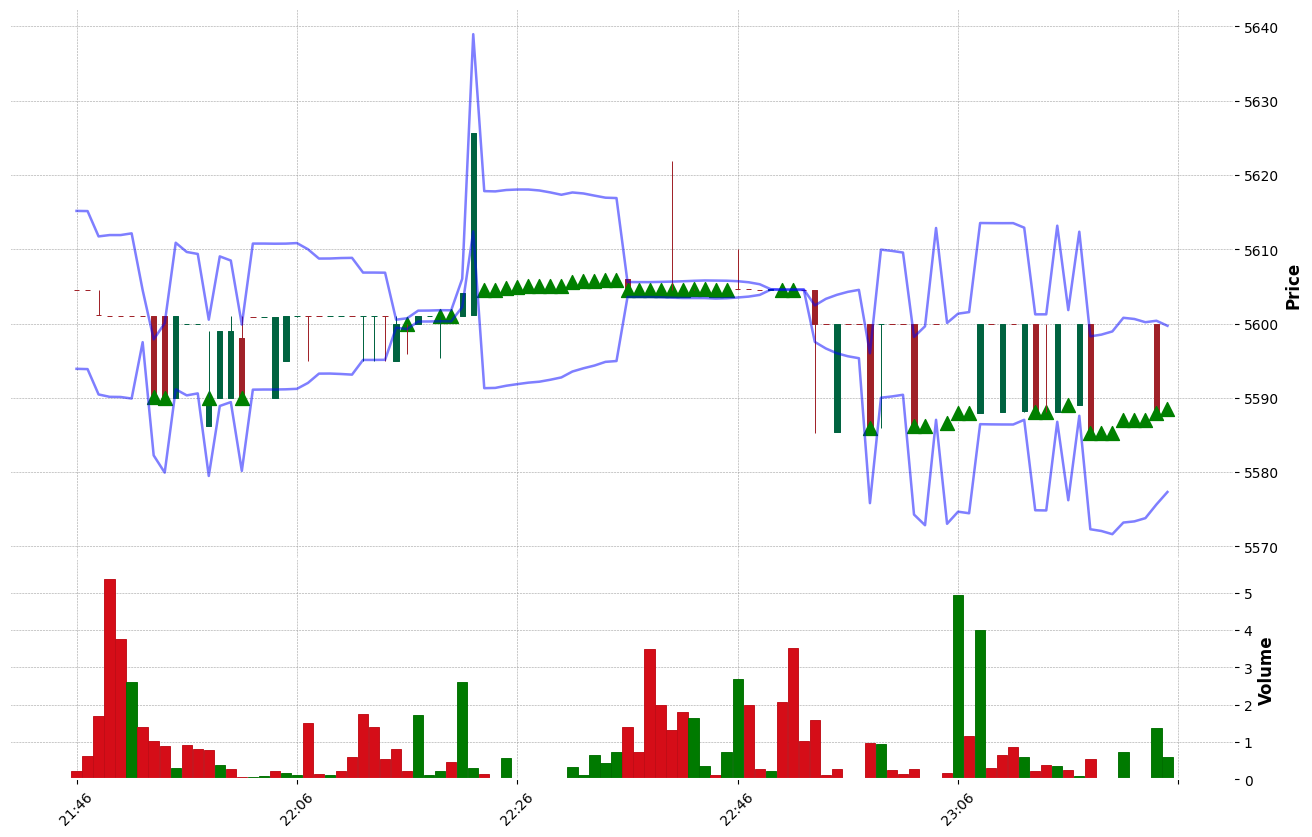

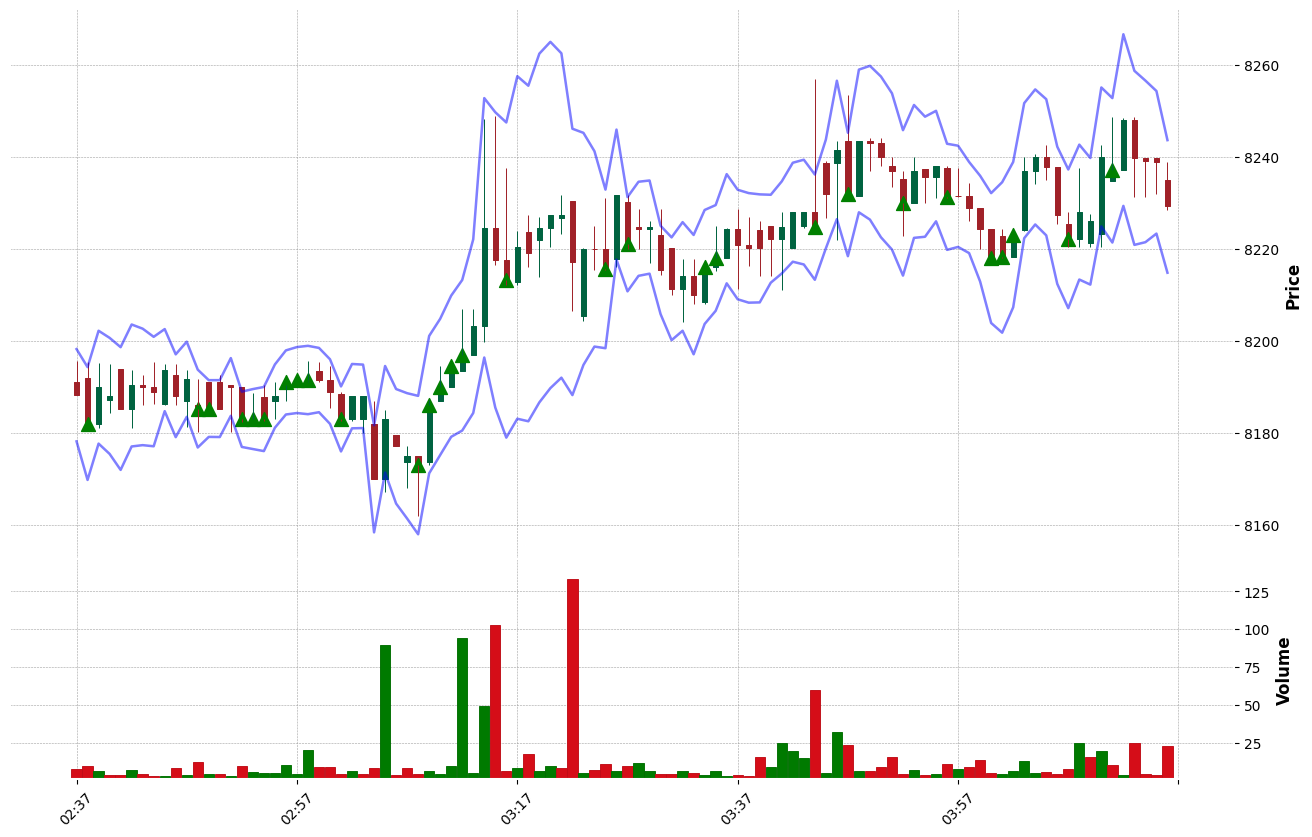

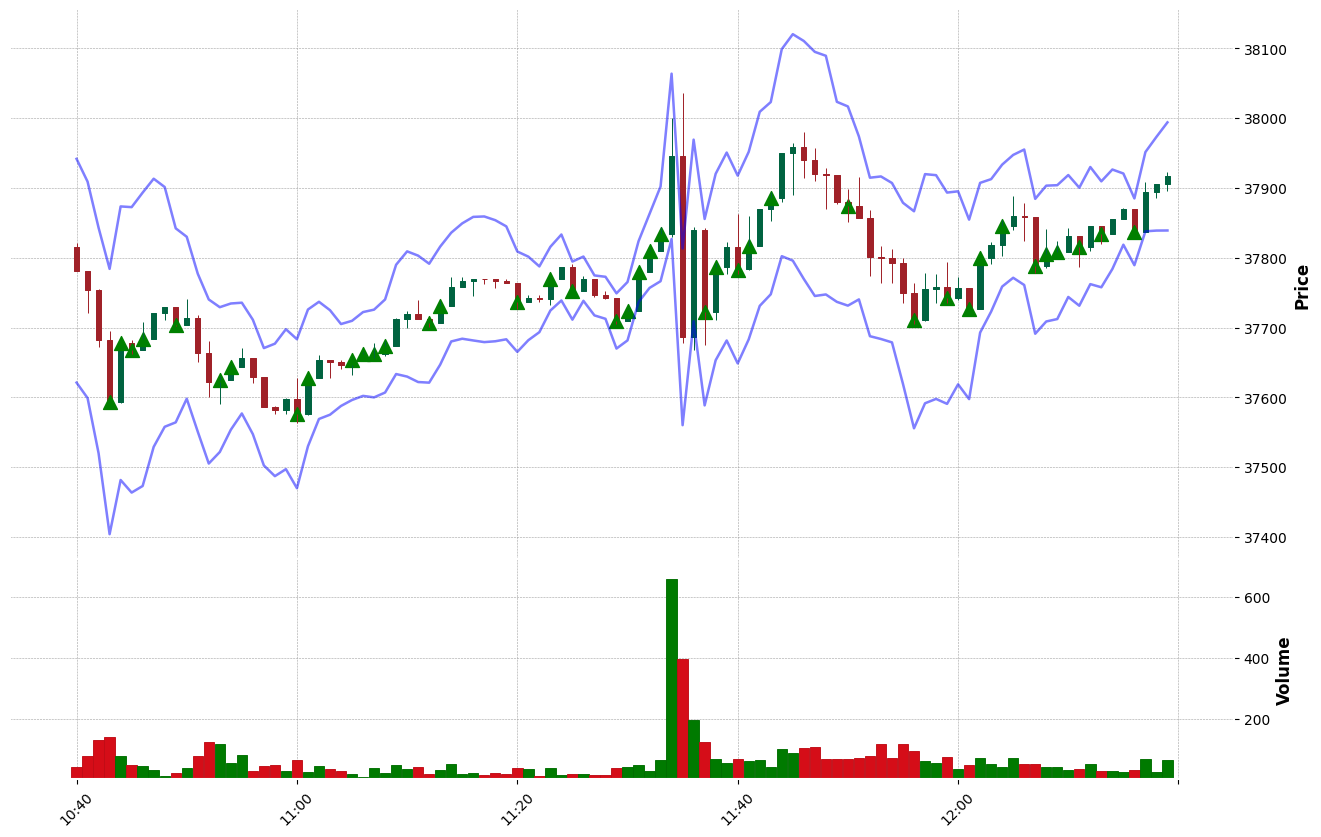

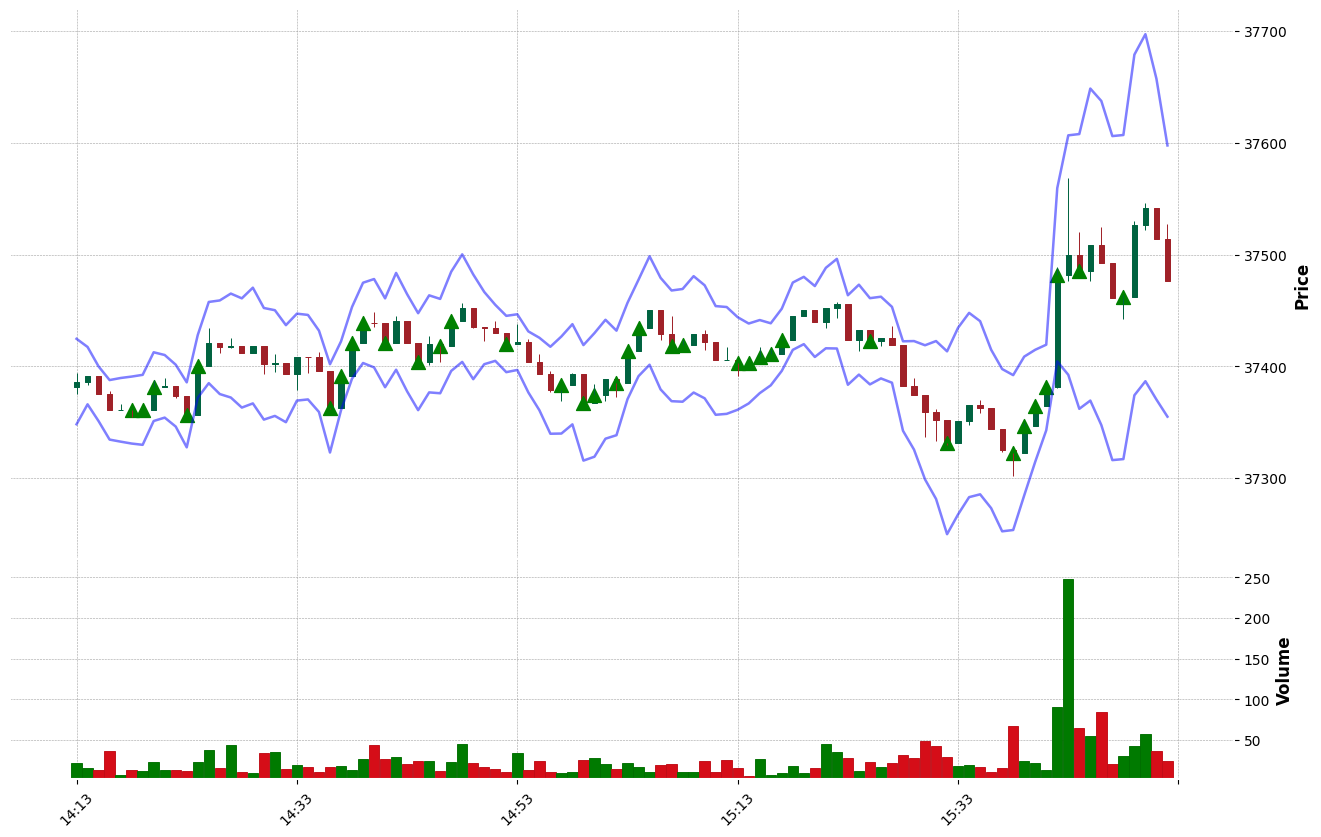

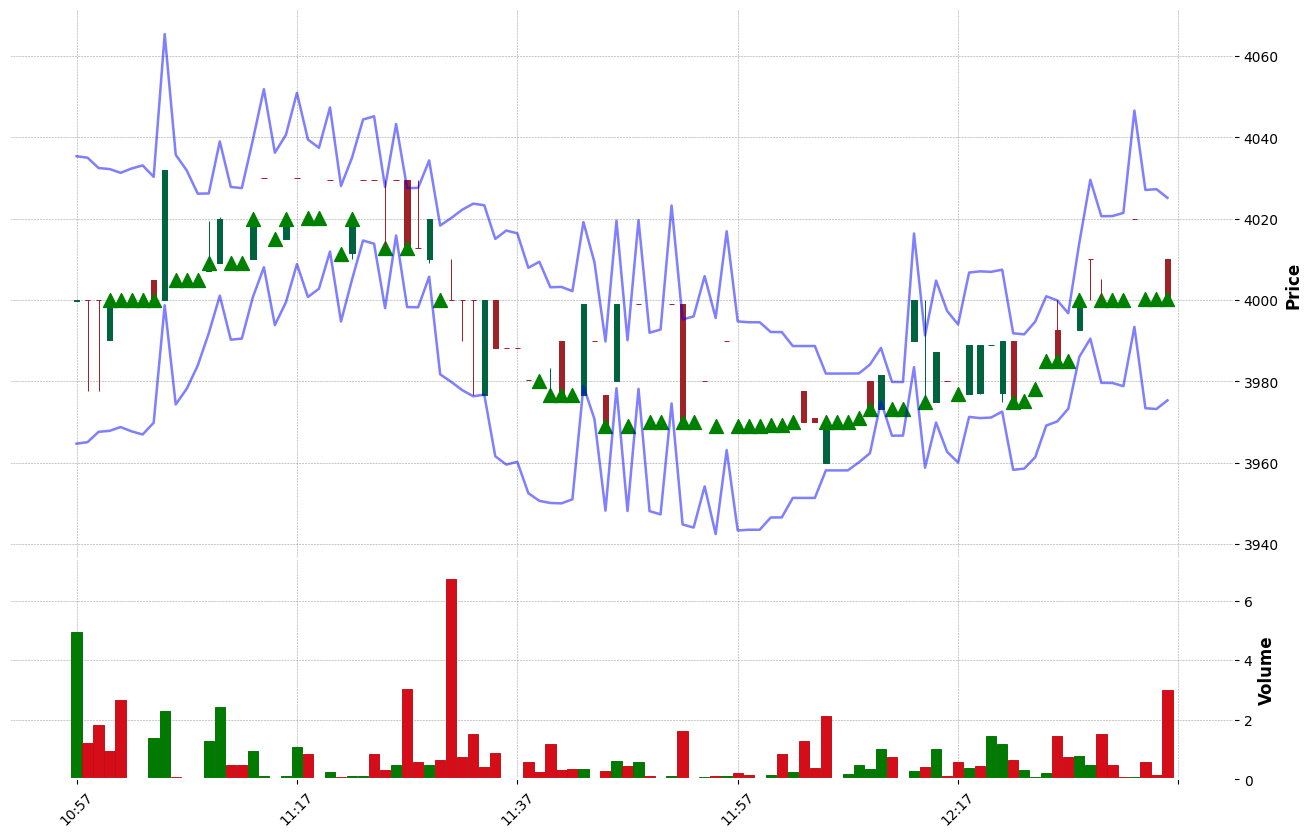

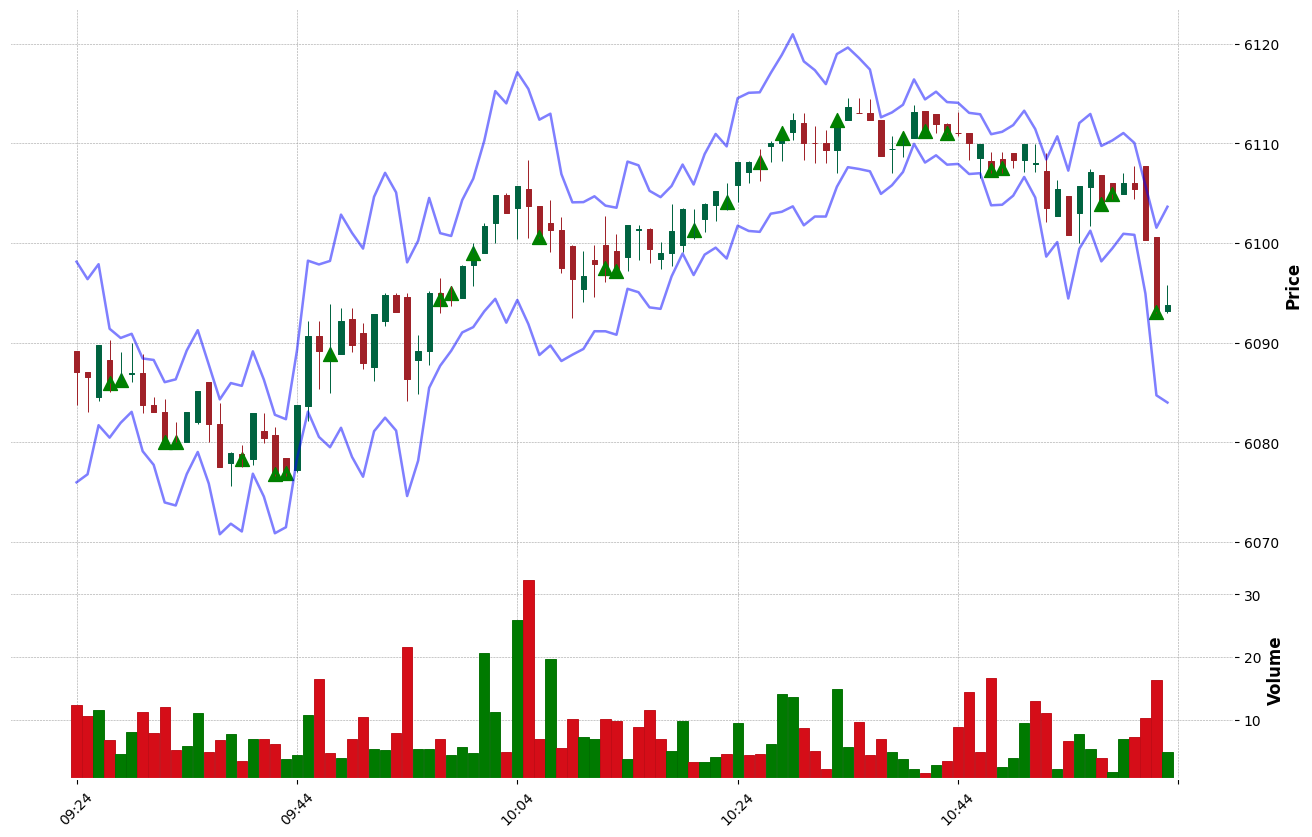

In [37]:
tmp_df = pd.read_csv('BTCUSD_output/BTCUSD_output_1T.csv', index_col='Date')
tmp_df.index = pd.to_datetime(tmp_df.index)
ft_plot_graphs(tmp_df)

# GENERATE DATASETS FOR TRAINING MODELS

In [52]:
def generate_model_data(df_name, candles_per_row, rows_per_file, output_folder, round_precision=3):
    # Read the dataframe
    df = pd.read_csv(df_name, index_col='Date')
    df.index = pd.to_datetime(df.index)

    # Create the output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    # Create the dataframe for training with the column length
    columns = []
    for i in range(candles_per_row):
        columns.extend([f'Open{i}',f'High{i}',f'Low{i}',f'Close{i}',f'Volume{i}'])
    columns.extend(["Output"])

    # Iterate over the dataframe row by row starting from candles_per_row because we adding candles backwards
    chunk_count=0
    rows=[]
    scaler = MinMaxScaler()
    for i in range(candles_per_row - 1, len(df)):
        # Create a row with OHCL and normalize (minmax to keep the shape of the graph)
        ohlc_row = []
        for j in range(candles_per_row):
            ohlc_row.extend([df['Open'].iloc[i-j],df['High'].iloc[i-j],df['Low'].iloc[i-j],df['Close'].iloc[i-j]])
        ohlc_row = scaler.fit_transform(np.array(ohlc_row).reshape(-1, 1))

        # Create volume row normalized with the last n volumes (also to keep the proportions)
        volume_row = []
        for j in range(candles_per_row):
            volume_row.extend([df['Volume'].iloc[i-j]])
        volume_row = scaler.fit_transform(np.array(volume_row).reshape(-1, 1))

        # Mix the row with the volume (Open, High, Low, Close, vol)[j]+...+(output)
        row = []
        for j in range(0, len(ohlc_row), 4):
            row.extend([
                ohlc_row[j][0],
                ohlc_row[j+1][0],
                ohlc_row[j+2][0],
                ohlc_row[j+3][0],
                volume_row[j // 4][0],
            ])
        row.extend([df.iloc[i, -1]]) # output (last column)

        # Add the row to the dataframe
        rows.append(row)
        if ((i+1) % (len(df) // 10) == 0):
            print(f"Processed {(i + 1) / (len(df)) * 100.0:.2f}% candles")

        # If max amount of rows reached save the file
        if (len(rows) == rows_per_file):
            print(f"Saving {output_folder}_{chunk_count}.csv'")
            chunk_df = pd.DataFrame(rows, columns=columns)
            chunk_df.round(round_precision).to_csv(f'{output_folder}/{output_folder}_{chunk_count}.csv', index=False)
            chunk_count += 1
            rows = []
    if (len(rows) > 0):
        print(f"Saving {output_folder}_{chunk_count}.csv'")
        chunk_df = pd.DataFrame(rows, columns=columns)
        chunk_df.round(round_precision).to_csv(f'{output_folder}/{output_folder}_{chunk_count}.csv', index=False)

    # Download the zip
    zipname = f"{output_folder}.zip"
    !zip -r {zipname} {output_folder}
    print(f"Downloading {zipname}")
    files.download(zipname)


In [53]:
generate_model_data(
    df_name='BTCUSD_output/BTCUSD_output_1H.csv',
    candles_per_row=100,
    rows_per_file=16384,
    output_folder= 'BTCUSD_dataset_1H_100candles',
    round_precision=3)

Processed 10.00% candles
Processed 20.00% candles
Saving BTCUSD_dataset_1H_100candles_0.csv'
Processed 30.00% candles
Processed 40.00% candles
Processed 50.00% candles
Saving BTCUSD_dataset_1H_100candles_1.csv'
Processed 60.00% candles
Processed 70.00% candles
Processed 80.00% candles
Saving BTCUSD_dataset_1H_100candles_2.csv'
Processed 90.00% candles
Processed 100.00% candles
Saving BTCUSD_dataset_1H_100candles_3.csv'
  adding: BTCUSD_dataset_1H_100candles/ (stored 0%)
  adding: BTCUSD_dataset_1H_100candles/BTCUSD_dataset_1H_100candles_1.csv (deflated 93%)
  adding: BTCUSD_dataset_1H_100candles/BTCUSD_dataset_1H_100candles_2.csv (deflated 93%)
  adding: BTCUSD_dataset_1H_100candles/BTCUSD_dataset_1H_100candles_3.csv (deflated 94%)
  adding: BTCUSD_dataset_1H_100candles/BTCUSD_dataset_1H_100candles_0.csv (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Check if dataset rows have the same shape as the real prices

In [54]:
def ft_load_dataset(dataset_name):
    # Extract and get the filenames of the dataset
    if not os.path.exists(dataset_name):
        print(f'Dataset {dataset_name} not found. Downloading...')
        os.system(f'unzip -q {dataset_name}.zip')
        print(f'Dataset {dataset_name} downloaded.')
    else:
        print(f'Dataset {dataset_name} found. Loading...')
    files = os.listdir(dataset_name)
    files.sort()
    files = [os.path.join(dataset_name, file) for file in files]

    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    return df

Dataset BTCUSD_dataset_1H_100candles found. Loading...


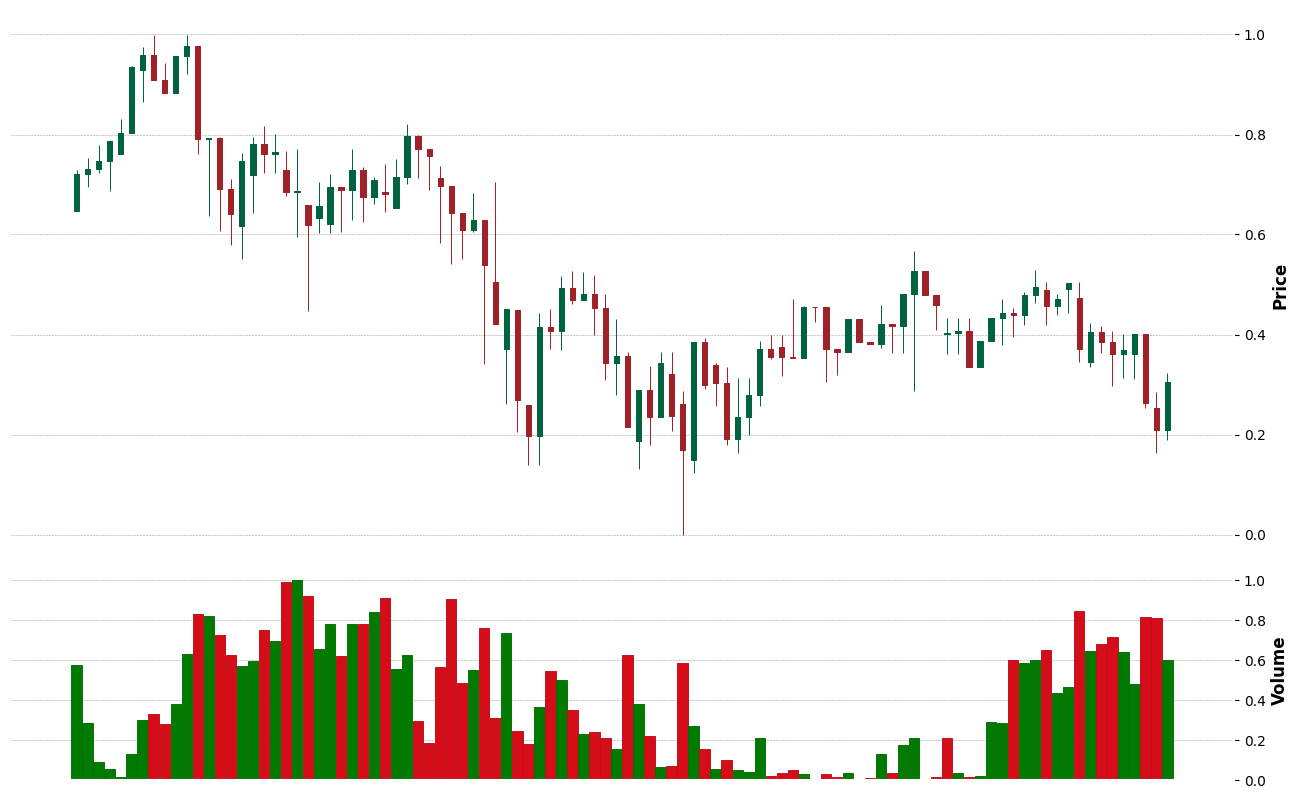

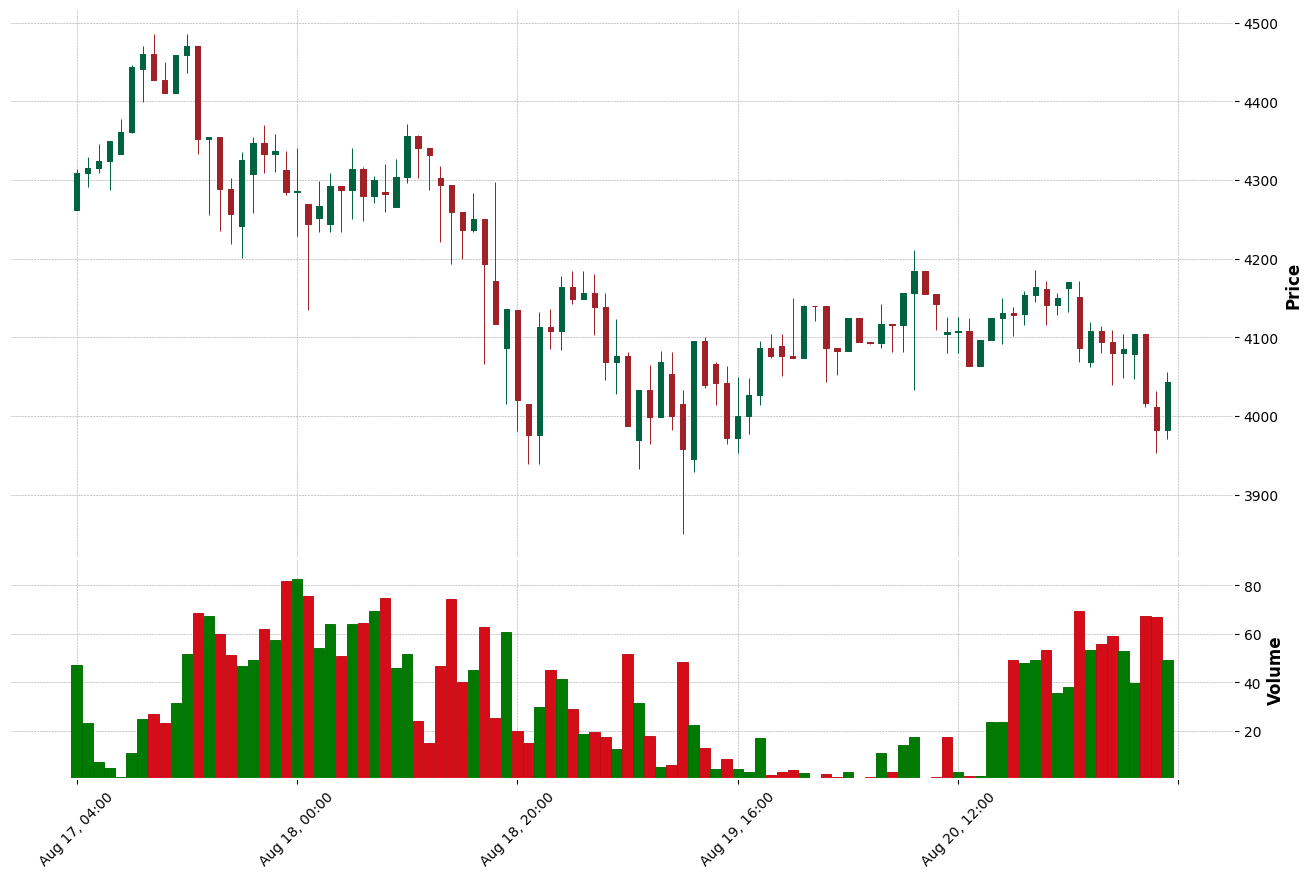

In [63]:
dataset_df = ft_load_dataset('BTCUSD_dataset_1H_100candles')
row_to_plot = 0

# Crear el DataFrame df con las columnas necesarias
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
rows = []
for i in range(len(dataset_df.columns) - 2,-1, -5):
    rows.append(dataset_df.iloc[row_to_plot, i-4:i+1].values)
df = pd.DataFrame(rows, columns=columns)

# Crear un índice de fecha ficticio
df.index = pd.date_range(start='2022-01-01', periods=len(df), freq='H')

# Ahora ploteamos df sin un índice de fecha visible
fig, axlist = mpf.plot(df, type='candle', style='charles', volume=True, figsize=(17, 11), returnfig=True)
for ax in axlist:
    ax.xaxis.set_visible(False)
plt.show()

# Cargar y preparar ref_df
ref_df = pd.read_csv('BTCUSD_graphs/BTCUSD_1H.csv', index_col='Date')
ref_df.index = pd.to_datetime(ref_df.index)

# Seleccionar el rango correcto de datos para ploteo
ref_df = ref_df.iloc[row_to_plot:row_to_plot + 100]

# Plotear ref_df con fechas
mpf.plot(ref_df, type='candle', style='charles', volume=True, figsize=(17, 11))